# Code for running the 3D incompressible SG solver

First load in the required packages and sub folders

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import initialconditions as ic

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

Next define the system parameters, the initial condition, and visualise the initial condition

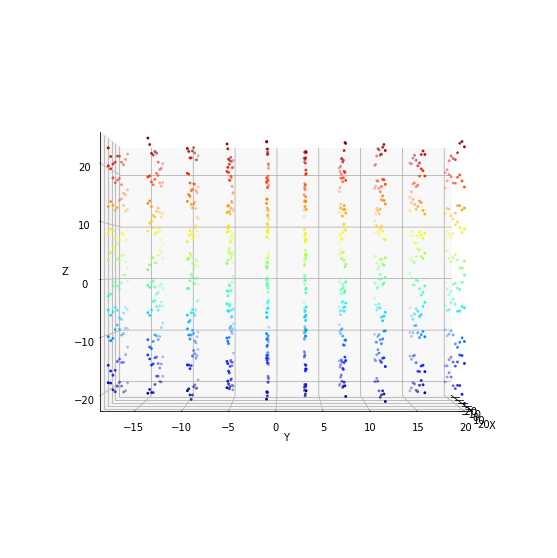

In [2]:
#System Parameters

N = 1000 # Number of seeds
box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = False # Set the periodicity of X
per_y = False # Set the periodicity of Y
per_z = False # Set the periodicity of Z
a = 8 # Set replication parameter
tf = 20 # Final time
Ndt = 1600 # Number of timesteps

#Initialize initial condition

# Z = ic.create_artificial_initial(N, box[0], box[1], box[2], box[3], box[4], box[5], 'lattice wsp', 0.9) #Create an artificial initial condition that is a lattice with a sine perturbation
B = np.array([[6, 2, 3], [2, 6, 5], [3, 5, 6]]) #Create background steady state
Z = ic.create_ss_initial(N, B, box, 'Thermal Sine') #Initial seed positions as a perturbation of a steady state
# Z = ic.create_cyc_initial(N, box, 0) #Initial seed positions for an isolated cyclone with no shear, shear can be set to 0.1

# Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8) #Points colored based on their 3rd component i.e. temperature
ax.set_xlim([np.min(Z[:,0]), np.max(Z[:,0])])
ax.set_ylim([np.min(Z[:,1]), np.max(Z[:,1])])
ax.set_zlim([np.min(Z[:,2]), np.max(Z[:,2])])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev = 0, azim = 0) #Viewing angle on the inital conditions

plt.show()

Next run the code

In [ ]:
main.SG_solver(box, Z, N, per_tol, tf, Ndt, per_x, per_y, per_z, a) #Solve and save the solution 

#Can activate the optional variables solver, and debug to control which linear solver the code uses and whether or not the code is in debug mode.

Next animate the solutions

In [ ]:
from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import PowerDiagram
import pyvista as pv
import imageio.v2 as iio

ani.point_animator('./SG_data.npz', 'C', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'C', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'Z', '2D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
ani.point_animator('./SG_data.npz', 'Z', '3D', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'

#Animate the cells

box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45]
domain = ConvexPolyhedraAssembly()
domain.add_box([box[0], box[1], box[2]], [box[3], box[4], box[5]])

# Load the data
loaded_data = np.load('SG_data.npz')

# Access the individual arrays
Z = loaded_data['data1']
C = loaded_data['data2']
w = loaded_data['data3']

#Compute Meridonal Velocities? and use them to color the cells
f = 1e-4
M = [[None for _ in range(len(w[0]))] for _ in range(len(w))]
for i in range(len(w)):
    for j in range(len(w[0])):
        M[i][j] = f * (Z[i][j][0] - C[i][j][0])

# Set up the animation parameters
n_frames = 800  # Number of frames

# Create an empty list to store frames
frames = []

# Generate frames for the animation
for i in range(n_frames):

    #Draw the tessellation
    pd = PowerDiagram(positions = Z[i] , weights = w[i] , domain = domain)

    # Store the volumes in an array
    vols = np.array(M[i])

    # Save the results in a .vtk file
    filename = "results.vtk"
    pd.display_vtk(filename)

    # Read the data
    grid=pv.read(filename)

    # create cell data that gives the cell volumes, this allows us to colour by cell volumes
    cell_vols = vols[grid.cell_data['num'].astype(int)]
    grid.cell_data['vols']=cell_vols

    # plot the data with an automatically created plotter, for a static picture use backend='static'
    plotter = pv.Plotter(window_size=[800,800], notebook = False, off_screen=True)
    plotter.add_mesh(grid)

    # Render the frame
    plotter.show()

    # Add a headlight
    light=pv.Light(light_type='headlight')
    plotter.add_light(light)

    # Get the frame as an image array
    frame = plotter.screenshot(transparent_background=True)

    # Add the frame to the list of frames
    frames.append(frame)

# Save the frames as an animation file
output_file = './animations/SG_Cells.gif'
iio.mimwrite(output_file, frames, format='gif', fps=40)